Mean proportion of arcs filled by the multi flow generation  0.3036352357320099
Mean/std proportion of flow in shortest paths  0.6834817791219847 0.007398320132166169
Median proportion of flow in shortest paths  0.6834913888284269
Size of heatmap  100 397
Size of heatmap  100 397
Minimal flow values range  19 30
Maximal flow values range  80 114
Heights histogram nodes in pairs {num_bin:val,...} 
{0: np.float64(0.222), 3: np.float64(0.222), 7: np.float64(0.222), 10: np.float64(0.333)}
Heights histogram flow passing through arcs {num_bin:val,...} 
{0: np.float64(0.176), 7: np.float64(0.279), 14: np.float64(0.168), 21: np.float64(0.194), 29: np.float64(0.108), 36: np.float64(0.054), 43: np.float64(0.014), 51: np.float64(0.002), 58: np.float64(0.003), 65: np.float64(0.002), 72: np.float64(0.001)}


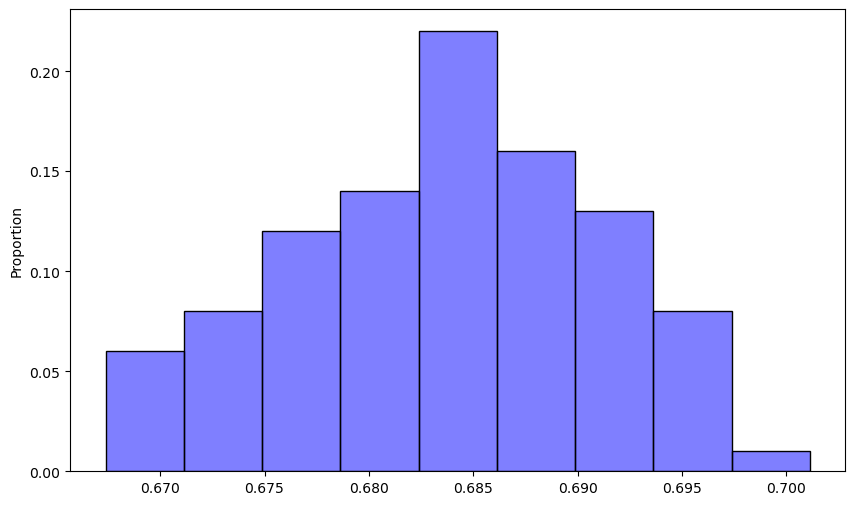

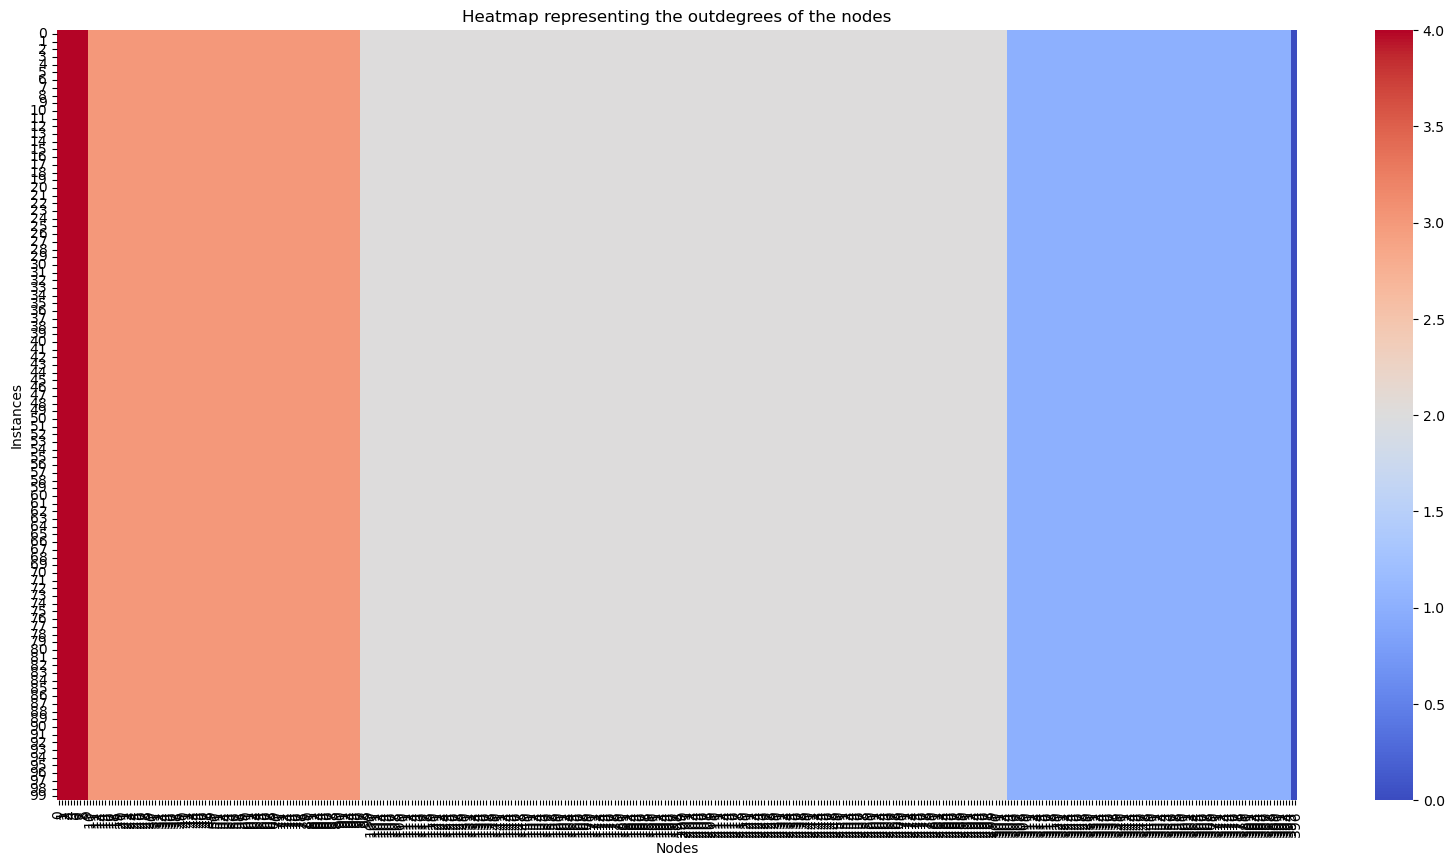

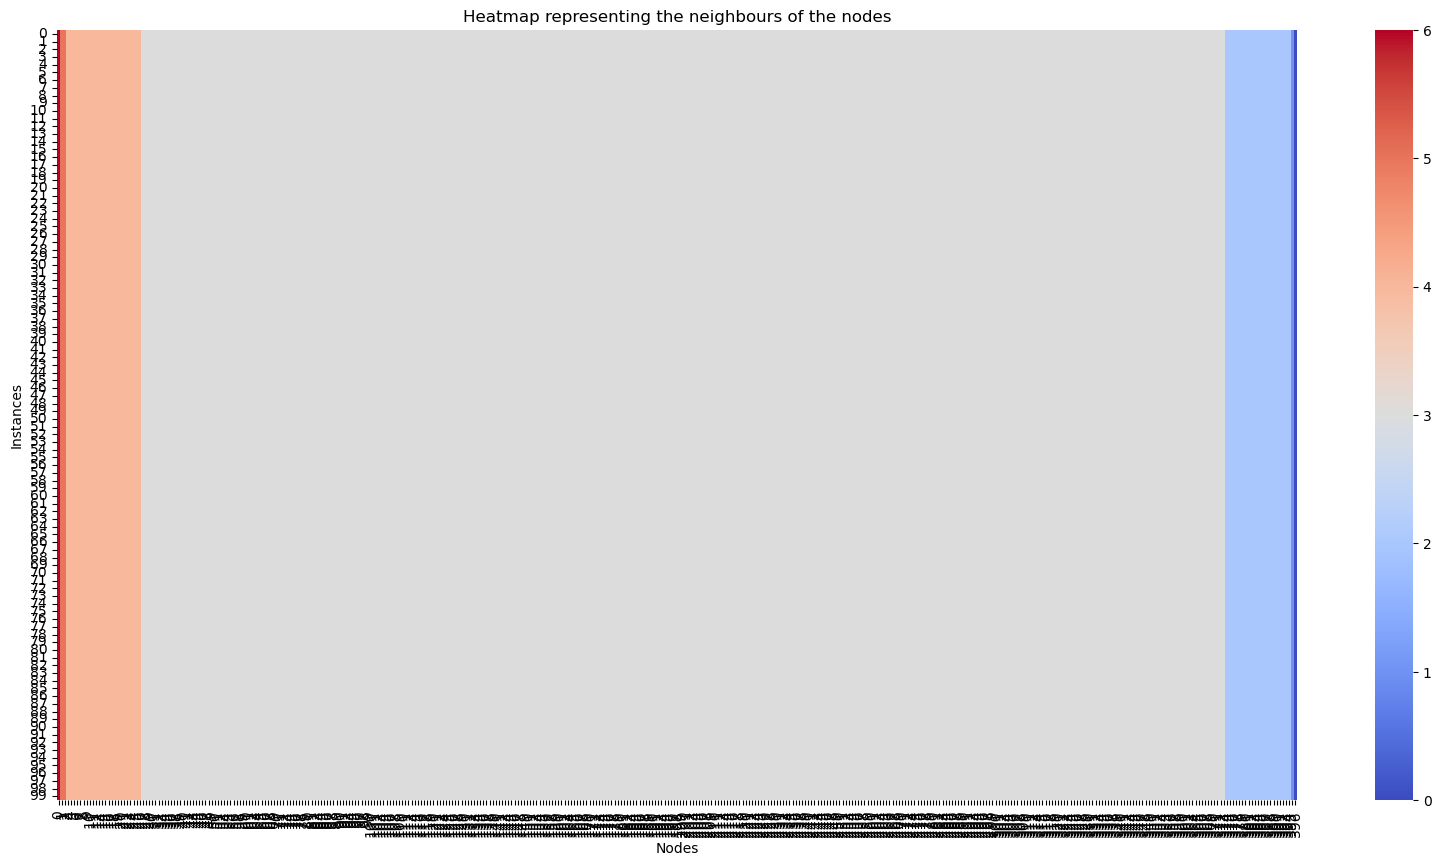

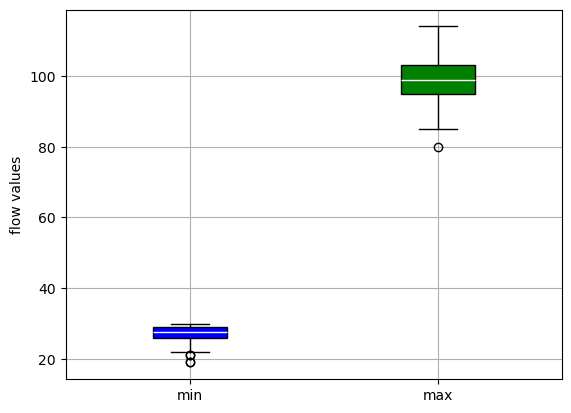

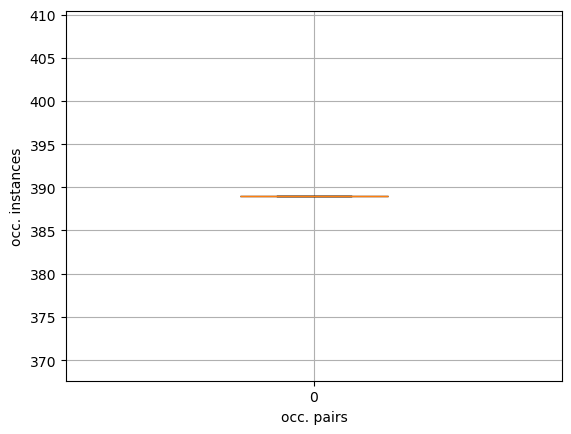

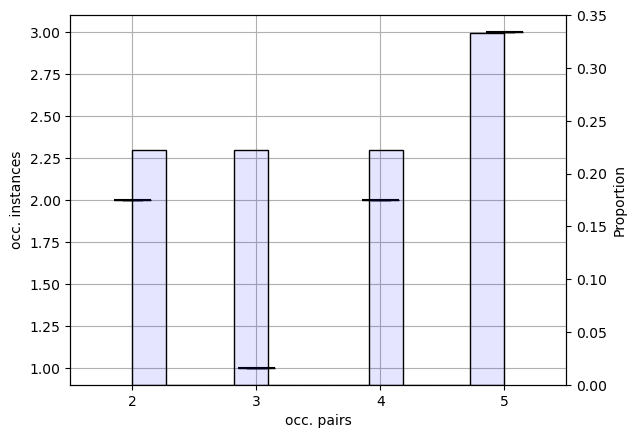

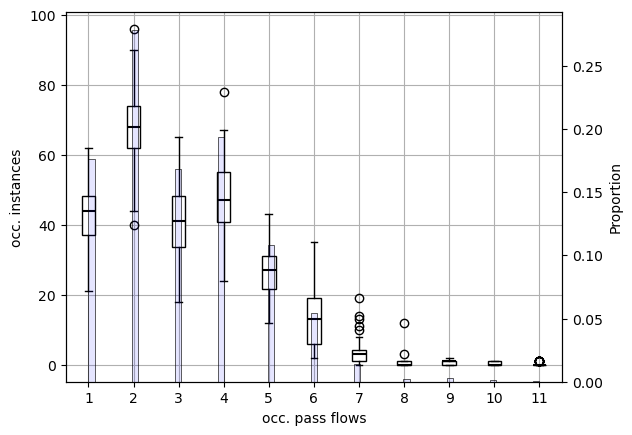

In [1]:
import os
import numpy as np
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')
from utils.graph_utils import get_arcs, out_degree, in_degree, get_neighbours
from utils.general_eval_msmd_metrics import instance_flow_proportion_shortest_paths


###########################################   Get the data   ################################################
dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]

dict_instances_multi_flow = np.load("data/real_data/pre_processed/LieuSaint/data_instances.npy", 
                                    allow_pickle = True).flatten()[0]



###########################################   Mean proportion of arcs filled   ###############################
graph = dict_original_network["graph"]
nb_arcs_graph = len(get_arcs(graph))
nb_arcs_by_inst = [len(get_arcs(dict_instances_multi_flow[(num_instance, 
                                                          _, 
                                                          _)][0].adj_mat))
                                                                for num_instance, _, _ in dict_instances_multi_flow]
mean_nb_arcs_inst = sum(nb_arcs_by_inst)/len(nb_arcs_by_inst)
print("Mean proportion of arcs filled by the multi flow generation ", mean_nb_arcs_inst/nb_arcs_graph)



###########################################   Proportions of flow in shortest paths   ##########################
prop_shortest_paths_by_instance = []
for num_instance, _, _ in dict_instances_multi_flow:
    mfd_instance = dict_instances_multi_flow[(num_instance, _, _)][0]
    prop_shortest_paths = instance_flow_proportion_shortest_paths (graph,
                                                                   mfd_instance.original_aggregated_flow, 
                                                                   mfd_instance.ideal_transport_times, 
                                                                   mfd_instance.pairs)
    prop_shortest_paths_by_instance.append(prop_shortest_paths)
print("Mean/std proportion of flow in shortest paths ", np.mean(prop_shortest_paths_by_instance), 
                                                np.std(prop_shortest_paths_by_instance, ddof = 1))
print("Median proportion of flow in shortest paths ", np.median(prop_shortest_paths_by_instance))
bins = 'auto'
fig = plt.figure(figsize = (10, 6))
g = sns.histplot(prop_shortest_paths_by_instance,
                color = "blue", 
                edgecolor = 'black', 
                alpha = 0.5,
                stat = 'proportion',
                bins = bins)
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "distribution_prop_fl_sp_"), 
                             bbox_inches='tight', 
                             pad_inches = 0)"""

###########################################   Put all data in one data structure   ################################################
update_transport_time, update_transition_functions = True, True
ls_instances_processed = []
for ind_instance, upd_transport_time, upd_transition_function in dict_instances_multi_flow:
    if upd_transport_time == update_transport_time and upd_transition_function == update_transition_functions:
        # Fetch the mfd instance
        mfd_instance, original_multi_flow = dict_instances_multi_flow[(ind_instance, upd_transport_time, upd_transition_function)]
        ls_instances_processed.append((ind_instance, 
                                       mfd_instance, 
                                       original_multi_flow))
ls_instances_processed.sort(key = lambda x : x[0])


###########################################   Degrees/neighbours calculations   ####################################################
perfs_means_dict = [(id_inst,
                     [None for _ in range(len(ls_instances_processed[0][1].adj_mat))]) 
                            for id_inst in range(len(ls_instances_processed))]
for instance_infos in ls_instances_processed:
    num_instance, mfd_instance = instance_infos[0], instance_infos[1]
    nb_nodegree = 0
    for node in range(len(mfd_instance.adj_mat)):
        out_degree_node = out_degree(graph, node)
        if out_degree_node == 0:
            in_degree_node = in_degree(graph, node) 
            if in_degree_node == 0: nb_nodegree += 1
        nb_neighbours = len(get_neighbours(graph, node))
        perfs_means_dict[num_instance][1][node] = (node, out_degree_node, nb_neighbours)
    # print("Instance ", num_instance, nb_nodegree)


###########################################   Showing heatmap of neighbours   ##########################################
perfs_means_dict.sort(key = lambda x : -np.mean([e[1] for e in x[1]]))
for elem in perfs_means_dict: elem[1].sort(key = lambda x : -x[1])
perfs_means_map = [[perfs_means_dict[id_inst][1][v][1] for v in range(len(ls_instances_processed[0][1].adj_mat))]
                                                            for id_inst in range(len(ls_instances_processed))]
print("Size of heatmap ", len(perfs_means_map), len(perfs_means_map[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(perfs_means_map, 
                 annot=False, fmt=".3f", cmap="coolwarm",  
                 xticklabels=list(range(len(perfs_means_map[0]))), 
                 yticklabels=[e[0] for e in perfs_means_dict])
# Set axis labels
ax.set_xlabel("Nodes")
ax.set_ylabel("Instances")
ax.set_title("Heatmap representing the outdegrees of the nodes")


###########################################   Showing heatmap of outdegrees   #########################################
perfs_means_dict.sort(key = lambda x : -np.mean([e[2] for e in x[1]]))
for elem in perfs_means_dict: elem[1].sort(key = lambda x : -x[2])
perfs_means_map = [[perfs_means_dict[id_inst][1][v][2] for v in range(len(ls_instances_processed[0][1].adj_mat))]
                                                            for id_inst in range(len(ls_instances_processed))]
print("Size of heatmap ", len(perfs_means_map), len(perfs_means_map[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(perfs_means_map, 
                 annot=False, fmt=".3f", cmap="coolwarm",  
                 xticklabels=list(range(len(perfs_means_map[0]))), 
                 yticklabels=[e[0] for e in perfs_means_dict])
# Set axis labels
ax.set_xlabel("Nodes")
ax.set_ylabel("Instances")
ax.set_title("Heatmap representing the neighbours of the nodes")



###########################################   Ranges of flow values   #########################################
# Constructing a boxplot showing how the minimal and maximal flow values are spread
ls_min_fl_val = [min(mfd_instance.original_flow_values) 
                    for mfd_instance, _ in dict_instances_multi_flow.values()]
print("Minimal flow values range ", min(ls_min_fl_val), max(ls_min_fl_val))
ls_max_fl_val = [max(mfd_instance.original_flow_values) 
                    for mfd_instance, _ in dict_instances_multi_flow.values()]
print("Maximal flow values range ", min(ls_max_fl_val), max(ls_max_fl_val))

fig = plt.figure()
box = plt.boxplot(ls_min_fl_val, 
                  patch_artist = True,
                  widths = 0.3,
                  positions = [0])
box['boxes'][0].set_facecolor("blue")
box['medians'][0].set_color("white")

box = plt.boxplot(ls_max_fl_val, 
                  patch_artist = True,
                  widths = 0.3,
                  positions = [1])
box['boxes'][0].set_facecolor("green")
box['medians'][0].set_color("white")
plt.xticks([0, 1], ['min', 'max'])
plt.ylabel("flow values")
plt.grid(visible = True)
# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "min_max_distributions"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""



###########################################    Points of interest    #########################################
# Constructing a histogram showing how many nodes are point of interests 
# (sources or destinations)
nb_pairs = 15
nb_instances = len(set(id_instance for id_instance, _, _ in dict_instances_multi_flow))
cpt_node_nbpis = [[0 for _ in range(nb_pairs+1)] for _ in range(nb_instances)]
for id_instance, _, _ in dict_instances_multi_flow:
    mfd_instance, multi_flow = dict_instances_multi_flow[id_instance, True, True]
    nb_nodes = len(mfd_instance.original_adj_mat)
    for node in range(nb_nodes):
        nb_times_pis = len([1 for s, t in mfd_instance.pairs if node == s or node == t])
        cpt_node_nbpis[id_instance][nb_times_pis] += 1

bins = 'auto'
fig, ax = plt.subplots()
plt.boxplot([cpt_node_nbpis[id_instance][0] 
                           for id_instance in range(nb_instances)], 
            patch_artist = True,
            widths = 0.3,
            positions = [0])
plt.xlabel("occ. pairs")
plt.ylabel("occ. instances")
plt.grid(visible = True)

fig, ax1 = plt.subplots()
medians = []
for nb_times in range(1, nb_pairs+1):
    if any(cpt_node_nbpis[id_instance][nb_times] > 0 
                for id_instance in range(nb_instances)):
        data = [cpt_node_nbpis[id_instance][nb_times] for id_instance in range(nb_instances)]
        medians.append(np.median(data))
        box = ax1.boxplot([cpt_node_nbpis[id_instance][nb_times] 
                           for id_instance in range(nb_instances)], 
                          patch_artist = True,
                          widths = 0.3,
                          positions = [nb_times])
        box['boxes'][0].set_facecolor("white")
        box['medians'][0].set(color = "black",
                              linewidth = 1.5)
plt.xlabel("occ. pairs")
plt.ylabel("occ. instances")
plt.grid(visible = True)

# Histogram
#fig2 = plt.figure()
summed_cpt_node_nbpis = np.sum(cpt_node_nbpis, axis = 0)
for i in range(1, len(summed_cpt_node_nbpis)):
    data += [i]*summed_cpt_node_nbpis[i]
ax2 = ax1.twinx() 
cumulative = False
g = sns.histplot(data,   
            color = "blue", 
            edgecolor = 'black', 
            alpha = 0.1,
            stat = 'proportion',
            cumulative = cumulative,
            bins = bins,
            ax = ax2)
h, i = {}, 0
for rectangle in g.patches:
    height = rectangle.get_height()
    if height != 0: h[i] = round(height, 3)
    i += 1
print("Heights histogram nodes in pairs {num_bin:val,...} ")
print(h)

# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "occ_node_pairs"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""

# Constructing a histogram showing how many arc is traversed by how many flow
nb_pairs = 15
nb_instances = len(set(id_instance for id_instance, _, _ in dict_instances_multi_flow))
cpt_arc_pairs = [[0 for _ in range(nb_pairs+1)] for _ in range(nb_instances)]
for id_instance, _, _ in dict_instances_multi_flow:
    mfd_instance, multi_flow = dict_instances_multi_flow[id_instance, True, True]
    nb_nodes = len(mfd_instance.original_adj_mat)
    arcs = get_arcs(mfd_instance.original_adj_mat)
    for u, v in arcs:
        nb_pass_flows = sum(int(multi_flow[i][u][v] > 0) 
                                for i in range(len(multi_flow)))
        cpt_arc_pairs[id_instance][nb_pass_flows] += 1

bins = 'auto'
fig, ax1 = plt.subplots()
for nb_times in range(nb_pairs+1):
    if any(cpt_arc_pairs[id_instance][nb_times] > 0 
           for id_instance in range(nb_instances)):
        box = plt.boxplot([cpt_arc_pairs[id_instance][nb_times] 
                           for id_instance in range(nb_instances)], 
                          patch_artist = True,
                          widths = 0.3,
                          positions = [nb_times])
        box['boxes'][0].set_facecolor("white")
        box['medians'][0].set(color = "black",
                              linewidth = 1.5)
plt.grid(visible = True)
plt.xlabel("occ. pass flows")
plt.ylabel("occ. instances")
# Histogram
#fig2 = plt.figure()
summed_cpt_arc_pairs, data = np.sum(cpt_arc_pairs, axis = 0), []
for i in range(len(summed_cpt_arc_pairs)):
    data += [i]*summed_cpt_arc_pairs[i]
ax2 = ax1.twinx()
cumulative = False  
g = sns.histplot(data,   
            color = "blue", 
            edgecolor = 'black', 
            alpha = 0.1,
            cumulative = cumulative,
            stat = 'proportion',
            bins = bins,
            ax = ax2)
h, i = {}, 0
for rectangle in g.patches:
    height = rectangle.get_height()
    if height != 0: h[i] = round(height, 3)
    i += 1
print("Heights histogram flow passing through arcs {num_bin:val,...} ")
print(h)

# Save the current figure
"""if save_path is not None:
    fig.savefig(os.path.join(save_path, 
                             "occ_flow_arcs"), 
                             bbox_inches='tight', 
                             pad_inches = 0)
"""

plt.show()


Size of heatmap  100 57
Size of heatmap  57 15
Size of heatmap  57 15


Text(0.5, 1.0, 'The demand by pair over instances')

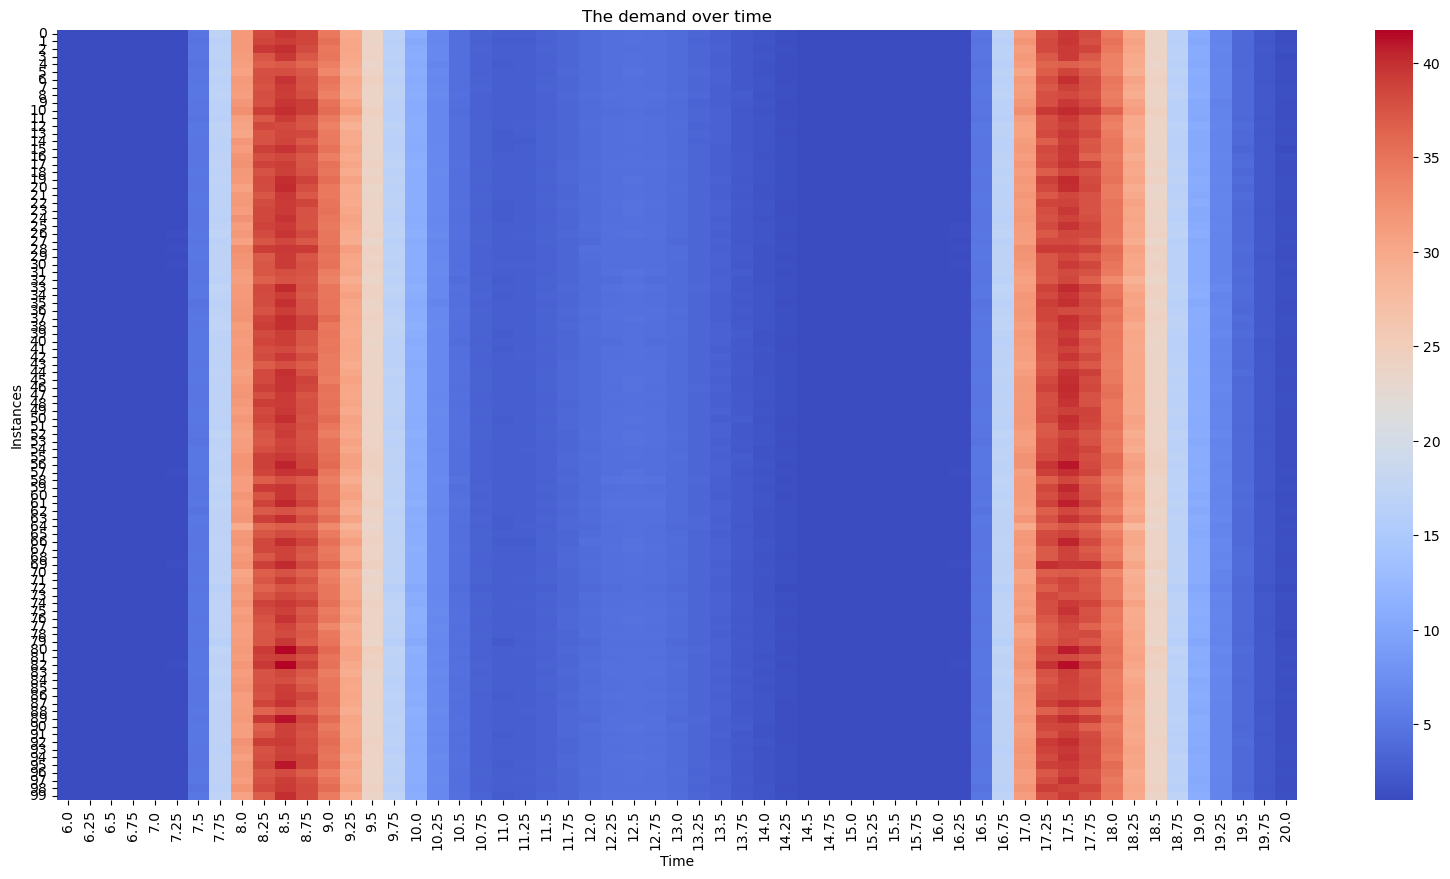

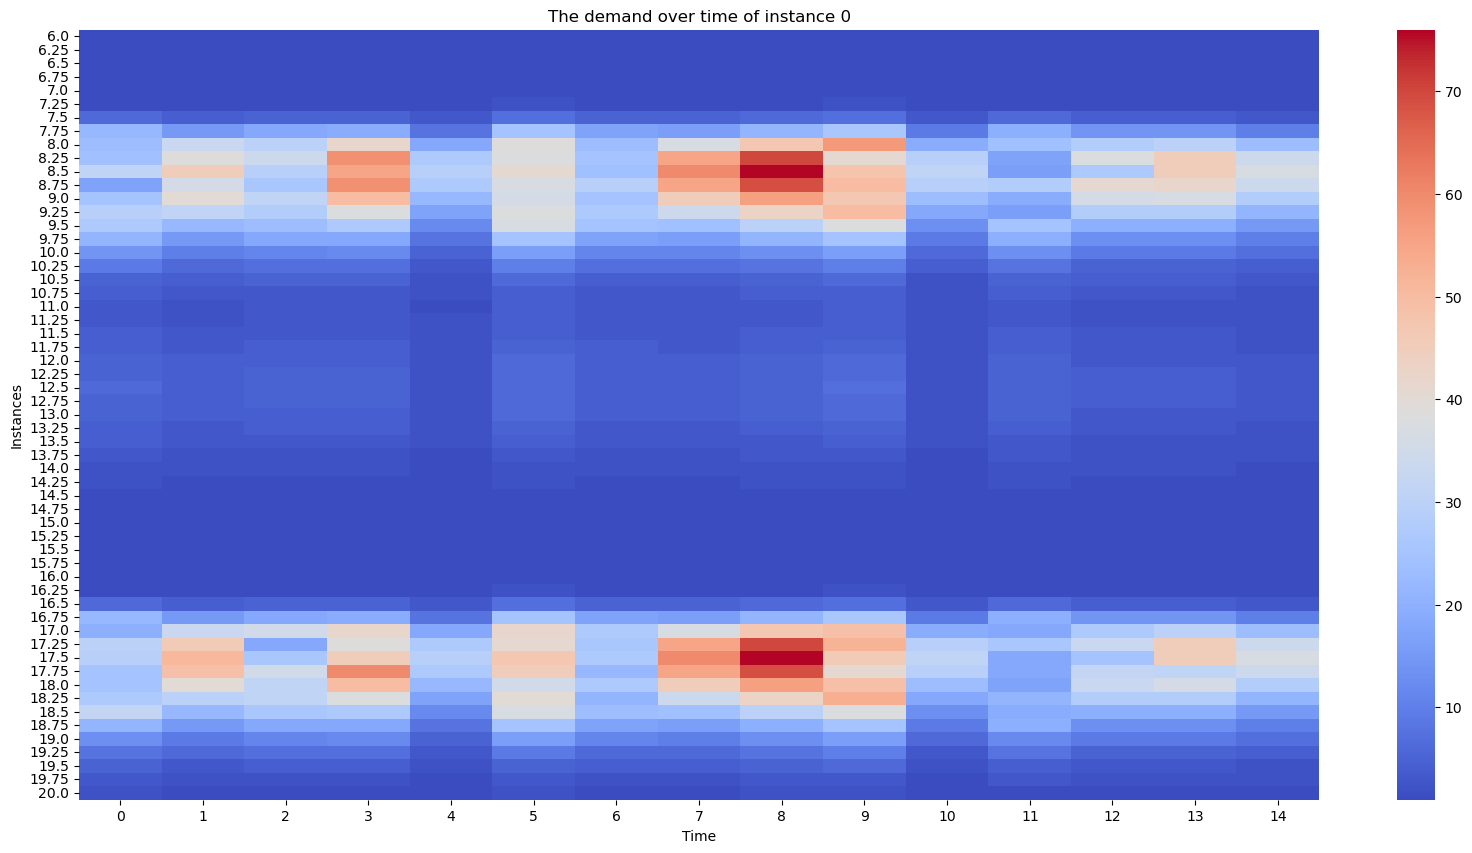

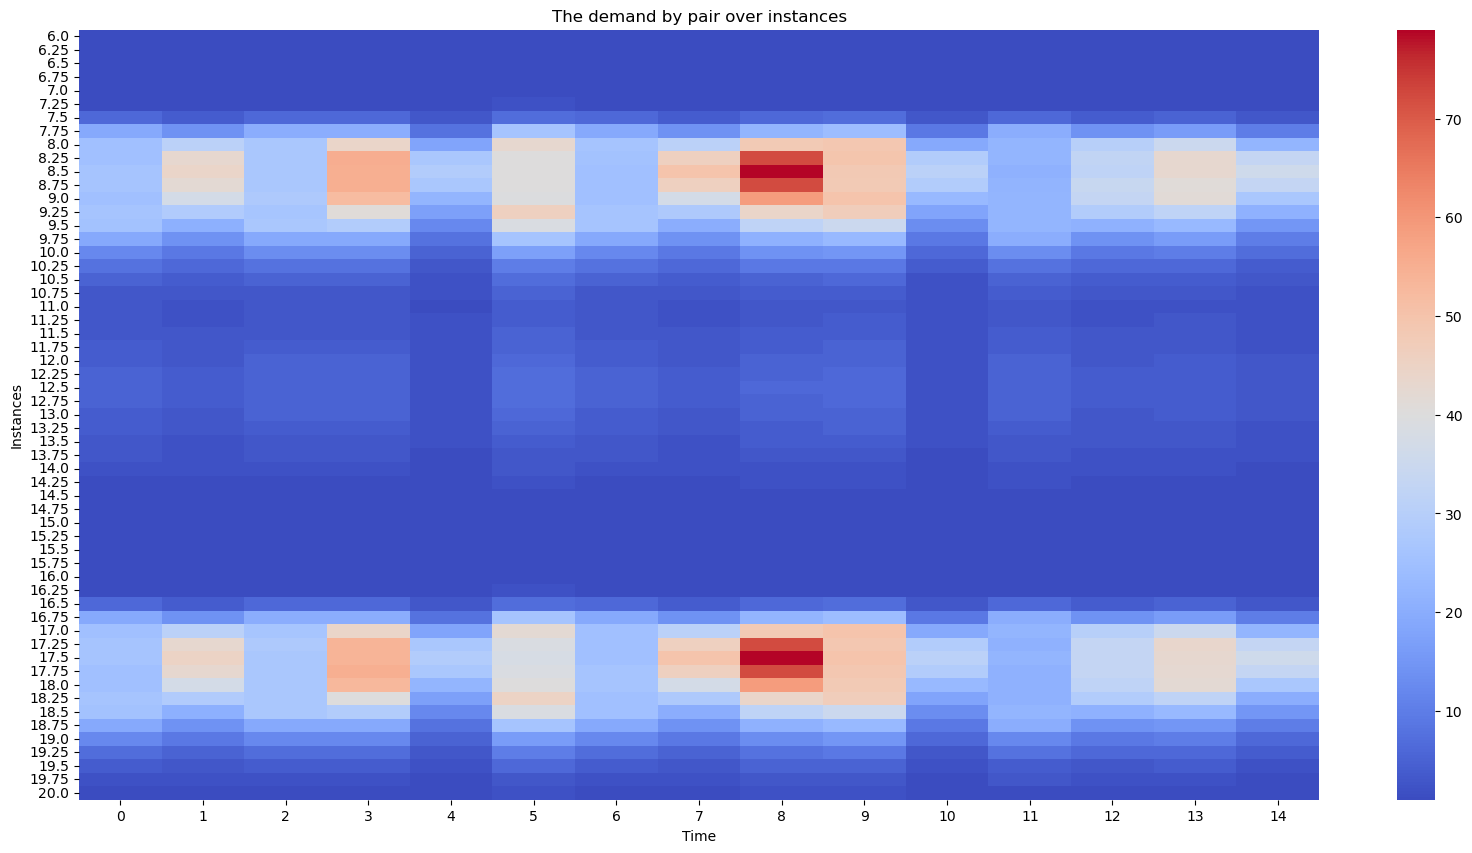

In [2]:
import os
import numpy as np
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')


dir_path_name = "data\data_simon\instances"
file_names = [f_name for f_name in os.listdir(dir_path_name) if os.path.isfile(os.path.join(dir_path_name, f_name)) and f_name[-4:] == ".npy"]
nb_instances, nb_pairs = 100, 15
dict_instances = {num_instance:{} for num_instance in range(nb_instances)}
for f_name in file_names:
    num_instance, time = int(f_name[:-4].split("_")[3]), float(f_name[:-4].split("_")[4])
    flow_values = np.load(os.path.join(dir_path_name, f_name), 
                          allow_pickle = True).flatten()[0]["flow_values"]
    dict_instances[num_instance][time] = flow_values


# Heatmap 1
list_times = sorted(list(dict_instances[num_instance].keys()), key = lambda x : float(x))
heatmap_data = [[sum(dict_instances[num_instance][time])/nb_pairs for time in list_times]
                                                                    for num_instance in dict_instances.keys()]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=sorted(list_times), 
                yticklabels=list(range(nb_instances)))
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand over time")


# Heatmap 2
instance_num = 0
heatmap_data = [dict_instances[instance_num][time] for time in list_times]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=list(range(nb_pairs)), 
                yticklabels=list_times)
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand over time of instance "+str(instance_num))


# Heatmap 3
heatmap_data = [np.median([dict_instances[instance_num][time] for instance_num in dict_instances],
                          axis = 0) for time in list_times]
print("Size of heatmap ", len(heatmap_data), len(heatmap_data[0]))
#linewidths=1.0,
# Create a heatmap
plt.figure(figsize=(20,10))
#plt.tick_params(axis='y', which='major', labelsize=10)
ax = sns.heatmap(heatmap_data, 
                annot=False, fmt=".3f", cmap="coolwarm",  
                xticklabels=list(range(nb_pairs)), 
                yticklabels=list_times)
# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Instances")
ax.set_title("The demand by pair over instances")

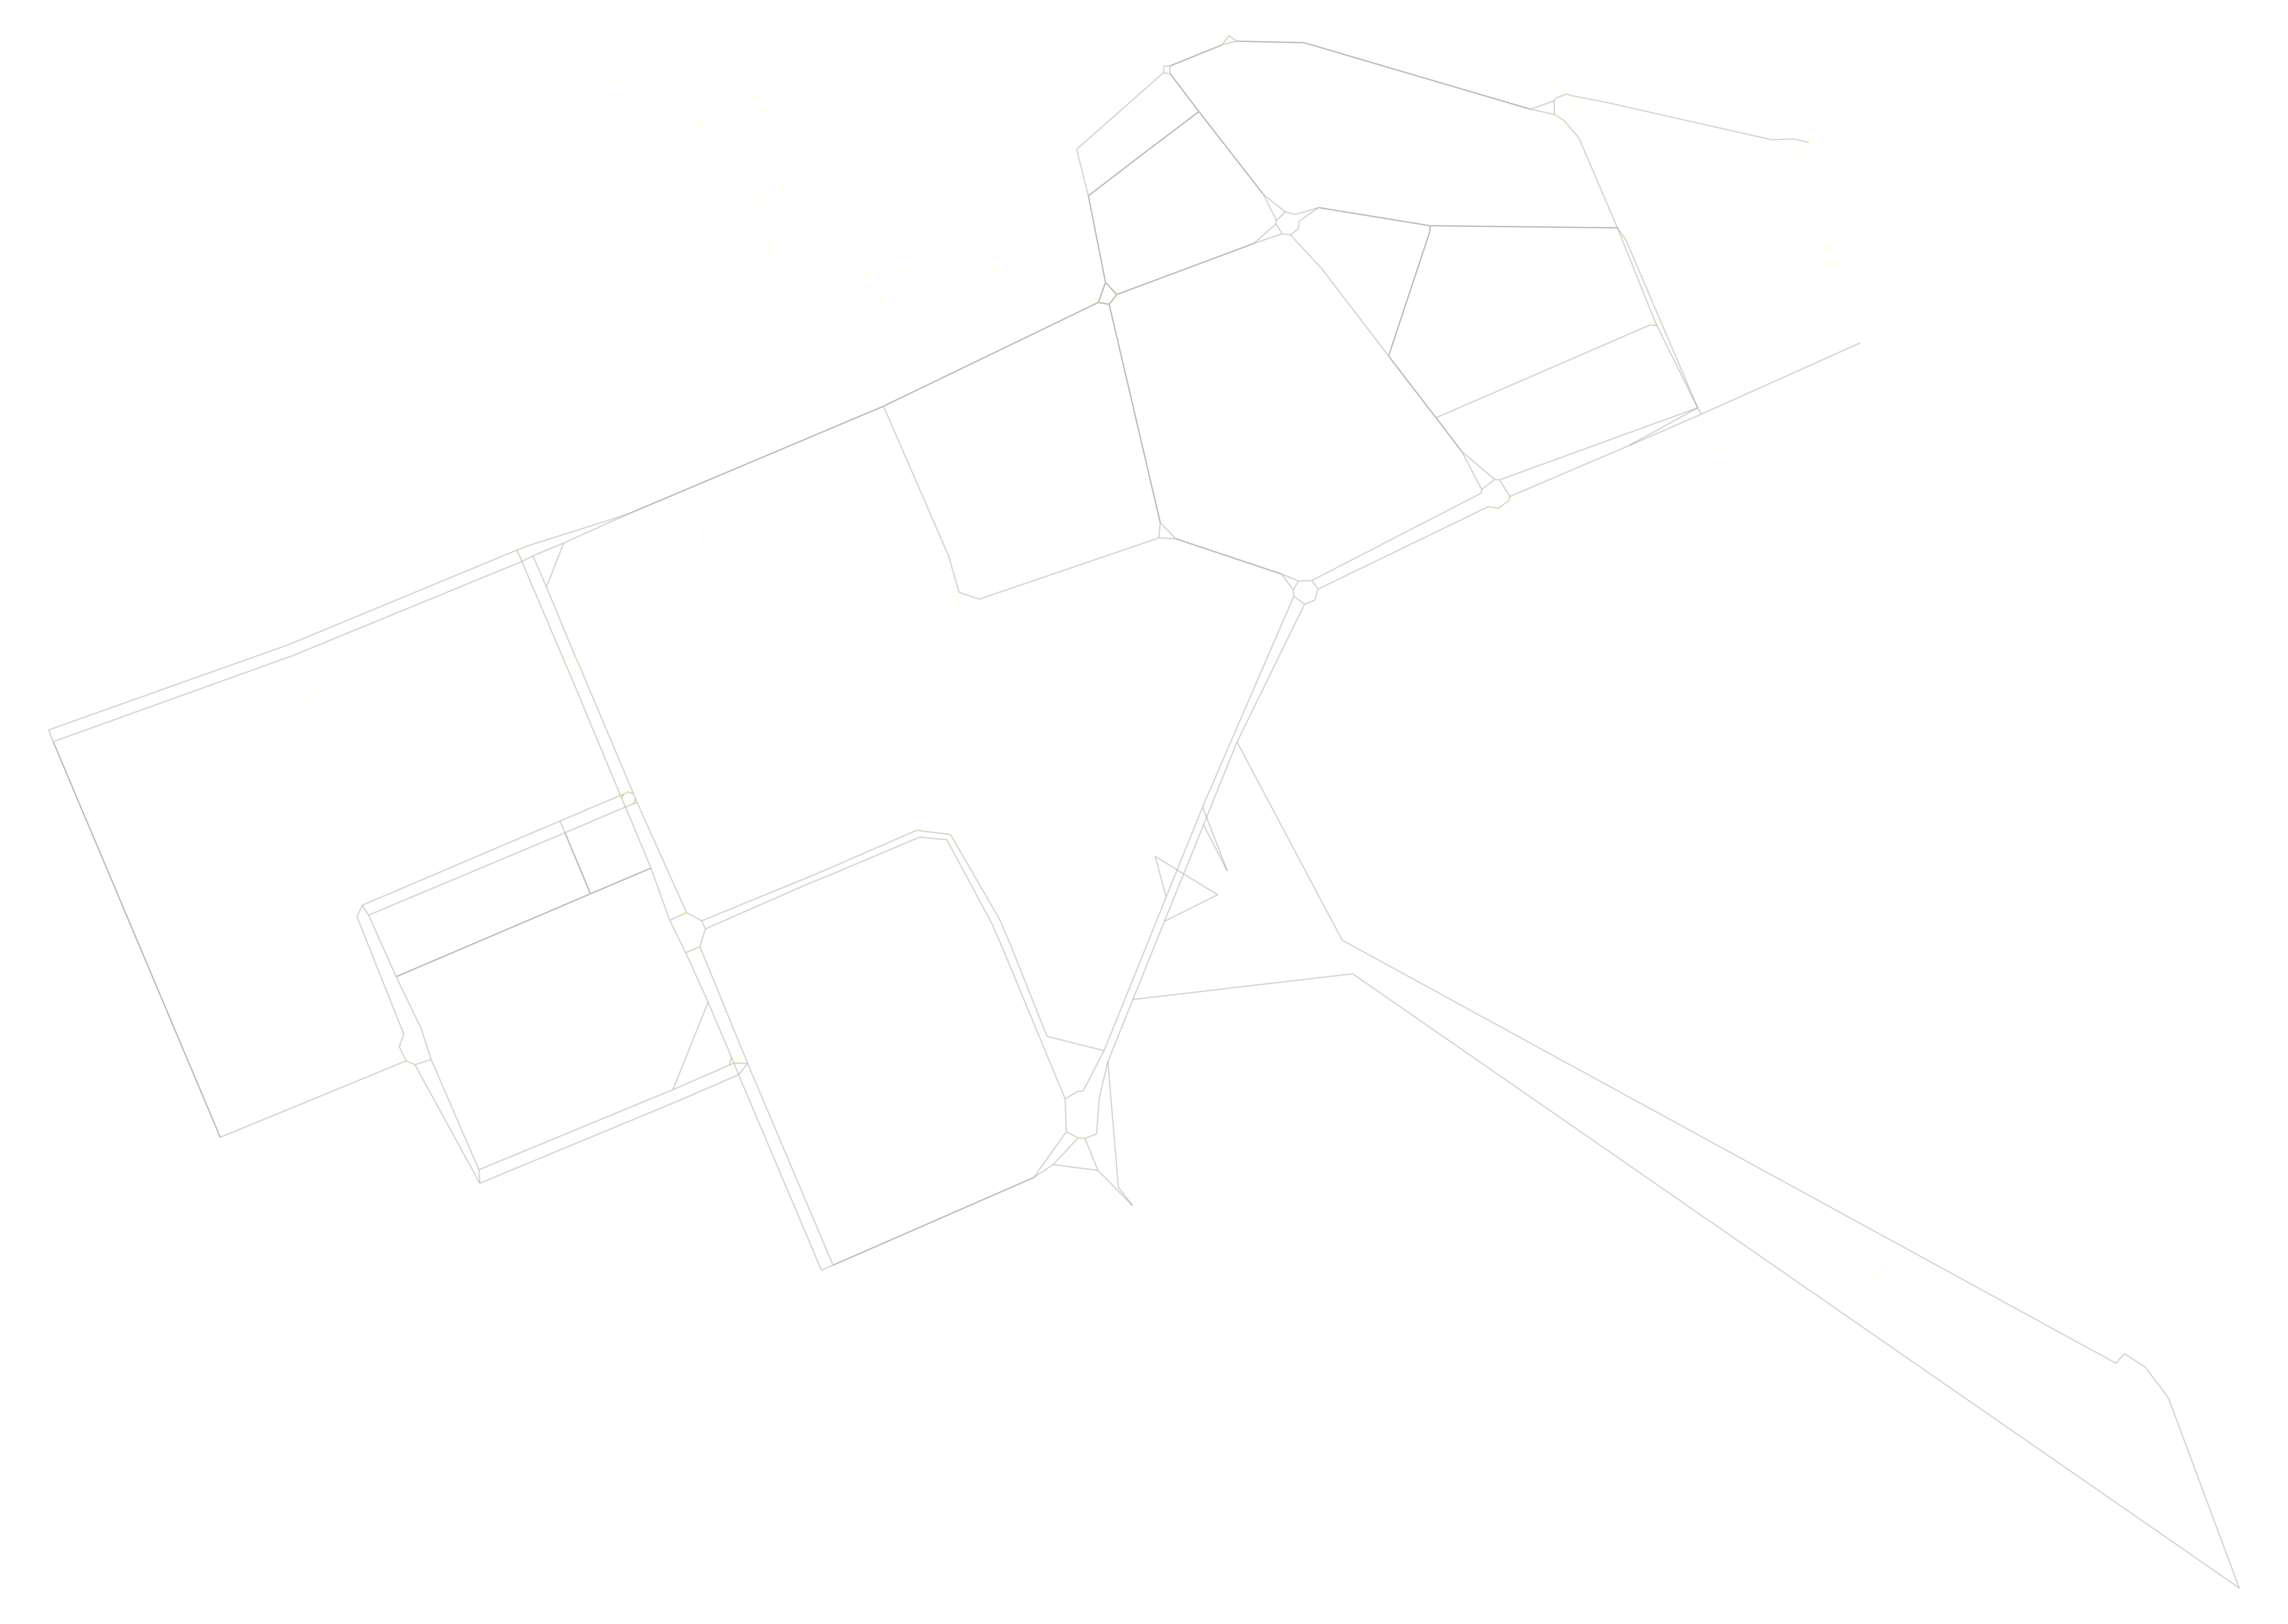

In [4]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import os
os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')
from utils.graph_utils import init_graph_arc_attribute_vals, get_arcs

"""set_id_nodes, list_edges, edge_colors = set(), list(), []
    for u, v, k, data in g.edges(keys = True, data = True):
        # Add first node 'u'
        set_id_nodes.add(u)
        # Add second node 'v'
        set_id_nodes.add(v)
        # Set the edge color
        if len(g[u][v]) > 1:
            if u == v:
                edge_color = "green"
            elif k==0: 
                edge_color = "blue"
            elif k==1:
                edge_color = "red"
            else:
                print("Edge multiplicity higher than expected.")
                #sys.exit()
        else:
            edge_color = "black"
        edge_colors.append(edge_color)
        list_edges.append((u, v, k, data))"""

with open("data/real_data/original_graphs/lieusaint.gpickle", 'rb') as f:
    original_nx_graph = pickle.load(f)
crs = original_nx_graph.graph['crs']
original_nx_nodes = list(original_nx_graph.nodes(data=True))

dict_original_network = np.load("data/real_data/pre_processed/LieuSaint/real_instance_lieusaint.npy", 
                                allow_pickle = True).flatten()[0]
graph = dict_original_network["graph"]
node_list_nx = dict_original_network["nodes"]


dict_instance_multi_flow = np.load("data/real_data/pre_processed/LieuSaint/multi_flow_instances/multi_flow_instance_0.npy", 
                                   allow_pickle = True).flatten()[0]
multi_flow = dict_instance_multi_flow["multi_flow"]
aggregated_flow = init_graph_arc_attribute_vals(graph)
arcs = get_arcs(graph)
for u, v in arcs: aggregated_flow[u][v] = sum(multi_flow[i][u].get(v, 0) for i in range(len(multi_flow)))

sub_g = nx.MultiDiGraph()
sub_g.graph['crs'] = crs
#sub_g.add_nodes_from([node_info for node_info in original_nx_nodes if node_info[0] in node_list_nx])
sub_g.add_nodes_from(original_nx_nodes)
edge_list_nx = [(node_list_nx[i], node_list_nx[j]) for i, j in dict_original_network["arcs"] if aggregated_flow[i].get(j, 0) > 0]
sub_g.add_edges_from(edge_list_nx)


fig, ax = ox.plot_graph(
    sub_g,
    figsize=(60, 60),
    node_color="yellow",
    node_size=5,
    #edge_color=edge_colors,
    edge_linewidth=2,
    edge_alpha=0.4,   # transparency (0 = fully transparent, 1 = opaque)
    node_alpha=0.4,
    bgcolor="white",
    show=True,
    close=True
)

plt.show()